# Deep Learning - Generative Adversarial Network (GAN)

### Van: Mart Veldkamp

In dit notebook trainen we een GAN voor de MNIST dataset.

De code in dit voorbeeld is gebaseerd op de code uit hoofdstuk 4 van *Generative Deep Learning* van David Forester, O'Reilly Media, 2019 en op hoofdstuk 8 van *Deep Learning with Python* door François Chollet, Manning, 2018..

# Inhoudsopgave

1. [Inleiding](#1)
2. [Het probleem](#2)
3. [Library's laden](#3)
4. [discriminator](#4)
5. [generator](#5)
6. [Adversarial Network](#6)
    - [Verover de data](#7)
7. [Trainen van een GAN](#8)
    - [Conclusie GAN](#9)

# 1. Inleiding <a class='anchor' id='1'></a>

Deze opdracht is onderdeel van het overkoepelende vak Deep Learning, dit is één van de meerdere opgaves die ik gebruik in dit vak om te laten zien hoe deep learning gebruikt kan worden voor verschillende doeleinde. Al deze opgaves zijn daarom ook op de lossen door middel van Deep Learning.

Alle code in deze opdrachten zijn van mijzelf, gebasseerd op code uit de lessen, of waar ik zelf vast liep gebaseerd op code snippets van het internet. Mocht het toch voorkomen dat er code 1 op 1 is overgenomen, dan staat dit vermeld in de bronnen

# 2. Het probleem <a class='anchor' id='2'></a>

Het probleem dat ik in deze notebook ga behandelen is het genereren van fotos aan de hand van voorbeelden, om zo hopelijk cijfers te genereren die wij als mens kennen. Dit gaan we doen aan de hand van een discriminator en een generator. De generator genereert fotos en de discriminator kijkt of deze fotos afwijken van "normale" fotos en voed deze informatie terug aan de generator.

# 3. Library's laden + data ophalen <a class='anchor' id='3'></a>

In [1]:
%matplotlib inline

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
import keras
from keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

import numpy as np

## Versie's van verschillende library's

In [2]:
print("Versie van Numpy:", np.__version__)
print("Versie van keras:", keras.__version__)

Versie van Numpy: 1.19.5
Versie van keras: 2.6.0


We gebruiken 20-dimensional vectoren of afbeeldingen te genereren.

In [10]:
input_dim = (28,28,1)
z_dim = 20

# 4. discriminator <a class='anchor' id='4'></a>

We maken eerst de discriminator. Deze krijgt als input een afbeelding en geeft als output of deze afbeelding echt is of niet.

In [11]:
discriminator_input = Input(shape = input_dim, name = 'discriminator_input')

x = Conv2D(32, kernel_size = 5, 
           strides = 2,
           padding = 'same',
           name = 'discriminator_conv_1', activation = 'relu')(discriminator_input)
x = Dropout(rate = 0.4)(x)

x = Conv2D(32, kernel_size = 5,
           strides = 2,
           padding = 'same',
           name = 'discriminator_conv_2', activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)

x = Conv2D(64, kernel_size = 5,
           strides = 2,
           padding = 'same',
           name = 'discriminator_conv_3', activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)

x = Conv2D(64, kernel_size = 5,
           strides = 1,
           padding = 'same',
           name = 'discriminator_conv_4', activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)

x = Flatten()(x)

discriminator_output = Dense(1, activation = 'sigmoid')(x)

discriminator = Model(discriminator_input, discriminator_output)

discriminator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 14, 14, 32)        832       
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
discriminator_conv_2 (Conv2D (None, 7, 7, 32)          25632     
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
discriminator_conv_3 (Conv2D (None, 4, 4, 64)          51264     
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 64)          0   

Dat het redelijk klein is ten opzichte van de generator. En daarin zie je dat 
er wordt af gewisseld tussen een conv2D en een Dropout layer, en om het 
af te sluiten een flatten + Dense layer. Deze structuur kan mogelijk komen om overfitting te voorkomen. Omdat dropout layers zorgen voor een 
gedistribueerde representatie van de informatie waardoor mogelijk 
informatie verloren gaat. 

Compileer het `discriminator` netwerk.

In [12]:
discriminator_optimizer = RMSprop(
    lr = 0.0008,
    clipvalue = 1.0,
    decay = 1e-8
)

discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# 5. Generator <a class='anchor' id='5'></a>

De `generator` maakt van een random vector een afbeelding.

In [13]:
initial_dense_layer_size = (7, 7, 32)

generator_input = Input(shape = (z_dim,), name = 'generator_input')

x = Dense(np.prod(initial_dense_layer_size))(generator_input)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)
x = Reshape(initial_dense_layer_size)(x)

x = UpSampling2D()(x)
x = Conv2D(64 ,kernel_size = 5, padding = 'same', name = 'generator_conv_1')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2D(64 ,kernel_size = 5, padding = 'same', name = 'generator_conv_2')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size = 5, padding = 'same', name = 'generator_conv_3')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = Conv2D(1, kernel_size = 5, padding = 'same', name = 'generator_conv_4')(x)

generator_output = Activation('tanh')(x)

generator = Model(generator_input, generator_output)

generator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 20)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1568)              32928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1568)              6272      
_________________________________________________________________
activation_5 (Activation)    (None, 1568)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
generator_conv_1 (Conv2D)    (None, 14, 14, 64)        5126

Wat je opvalt is het erg veel layers heeft, en daarin veel verschillende 
soorten layers, zoals convelutional layers maar ook activatie en dense 
layers.  

# 6. Adversarial Network <a class='anchor' id='6'></a>

Het volledige Adversarial Network combineert de `generator` en de `discriminator`. Voordat we het model compileren, geven we aan dat de parameters van de `discriminator` in dit geval niet mogen veranderen. Anders zou de `discriminator` simpelweg alle afbeeldingen als echt bestempelen.

In [14]:
discriminator.trainable = False

gan_input = Input(shape = (z_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 1e-8)

gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

discriminator.trainable = True

## Verover de data <a class='anchor' id='7'></a>

In [15]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# 7. Trainen van een GAN <a class='anchor' id='8'></a>

Let op: dit vereist heel veel geduld en een snelle computer, liefst met een GPU.
Probeer een paar iteraties te runnen.

discriminator loss: 0.7100896239280701 ,acc: 0.0
	discriminator loss (real): 0.7085728645324707 , acc (real:) 0.0
	discriminator loss (fake): 0.7085728645324707 , acc (fake:) 0.0
adversarial loss: 0.6475754976272583 , acc: 1.0


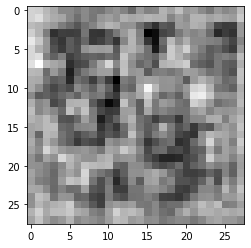

discriminator loss: 0.6675936579704285 ,acc: 0.0
	discriminator loss (real): 0.15748131275177002 , acc (real:) 0.0
	discriminator loss (fake): 0.15748131275177002 , acc (fake:) 0.0
adversarial loss: 3.4063994884490967 , acc: 0.05000000074505806


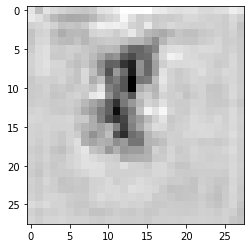

discriminator loss: -0.24799080938100815 ,acc: 0.0
	discriminator loss (real): 0.16679050028324127 , acc (real:) 0.0
	discriminator loss (fake): 0.16679050028324127 , acc (fake:) 0.0
adversarial loss: 28.378814697265625 , acc: 0.0


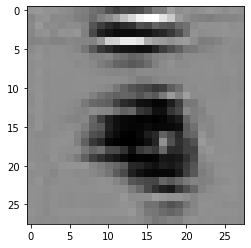

discriminator loss: -0.012338869273662567 ,acc: 0.0
	discriminator loss (real): 0.17352578043937683 , acc (real:) 0.0
	discriminator loss (fake): 0.17352578043937683 , acc (fake:) 0.0
adversarial loss: 36.626060485839844 , acc: 0.05000000074505806


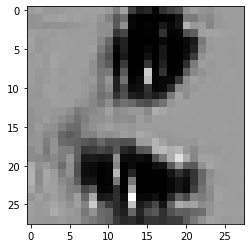

In [16]:
import matplotlib.pyplot as plt

iterations = 400
batch_size = 20

start = 0
for step in range(iterations):
    stop = start + batch_size
    
    # genereer afbeeldingen
    random_latent_vectors = np.random.normal(size = (batch_size, z_dim))
    generated_images = generator.predict(random_latent_vectors)
    
    fake = np.ones((batch_size, 1))
    fake += 0.05 * np.random.random(fake.shape) # voeg een beetje ruis toe aan de labels
    
    # selecteer echte afbeeldingen
    real_images = x_train[start: stop]
    valid =  np.zeros((batch_size, 1))
    valid += 0.05 * np.random.random(valid.shape) # voeg een beetje ruis toe aan de labels 
    
    # train de discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_images, valid)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(generated_images, fake)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    # nieuwe willekeurige vectoren
    random_latent_vectors = np.random.normal(size = (batch_size, z_dim))
    
    # geef deze allemaal het label 'echt' (maar dat zijn ze niet)
    misleading = np.zeros((batch_size, 1))
    
    # train de gewichten van de generator door het trainen van de gan als geheel
    a_loss, a_acc = gan.train_on_batch(random_latent_vectors, misleading)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 == 0:        
        print('discriminator loss:', d_loss, ',acc:', d_acc)
        print('\tdiscriminator loss (real):', d_loss_real, ', acc (real:)', d_acc_real)
        print('\tdiscriminator loss (fake):', d_loss_real, ', acc (fake:)', d_acc_real)
        print('adversarial loss:', a_loss, ', acc:', a_acc)
        
        img = generated_images[0].reshape((28,28))
        plt.imshow(img, cmap='gray_r')
        plt.show()

## Conclusie GAN <a class='anchor' id='9'></a>

De conclusie dat we kunnen trekken uit deze simpele GAN is dat het toch 
best moeilijk is om zelf foto’s te genereren voor een GAN. En dat dit 
(misschien) meer kracht en geduld nodig heeft voor betere resultaten. We 
zien wel dat er een figuur uit ontstaat ten opzichte van de eerste iteraties. 
Maar nog niet iets wat te herkennen is als mens.